In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '../scripts/')
from utils import *
from processing import *
import pickle
from hyperopt import tpe, fmin, hp
from hyperopt.pyll.base import scope
from sklearn.decomposition import PCA
import shap
import torch
from torch import nn 
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [2]:
lead = 0
obs = 1

## Loading Data

In [9]:
# Original data
data = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_dataset_no_pts.csv".format(lead, obs, lead, obs), low_memory=False)
data["mv_duration_ratio"] = data["mv_duration"]/data["LOS"]
data

,PatientStayID,Class,LOS,Age,APACHEIVscore,APACHEIVaScore,UrgentAdmission,AdmissionCategory,NumBeds,TeachingStatus,...,comorbidity_drug,comorbidity_depre,last_24hr_urine,tranfuse_rbc,tranfuse_plasma,tranfuse_platelet,dialysis,surgical,mv_duration,mv_duration_ratio
0,150934,1,826.0,69.0,78.0,78.0,1.0,4.0,2.0,0,...,0.0,0.0,NaN,0,0,0,1,0,0.0,0.000000
1,151708,1,2007.0,79.0,38.0,38.0,1.0,4.0,4.0,1,...,0.0,0.0,300.0,0,0,0,0,0,0.0,0.000000
2,152171,1,2380.0,84.0,38.0,38.0,0.0,4.0,2.0,0,...,0.0,0.0,NaN,0,0,0,0,1,0.0,0.000000
3,155126,1,3521.0,71.0,65.0,65.0,0.0,4.0,4.0,1,...,0.0,0.0,NaN,1,0,0,0,1,477.0,0.135473
4,156970,1,17999.0,56.0,32.0,32.0,1.0,4.0,4.0,1,...,0.0,0.0,1870.0,0,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22373,3352487,0,720.0,60.0,45.0,45.0,0.0,4.0,4.0,0,...,NaN,NaN,2470.0,0,0,0,0,1,0.0,0.000000
22374,3352563,0,923.0,34.0,54.0,54.0,1.0,4.0,2.0,0,...,0.0,0.0,1555.0,0,0,0,0,0,0.0,0.000000
22375,3352747,0,1006.0,30.0,31.0,31.0,1.0,4.0,4.0,0,...,0.0,0.0,2700.0,0,0,0,0,0,0.0,0.000000
22376,3353044,0,3398.0,52.0,41.0,41.0,1.0,4.0,2.0,0,...,0.0,0.0,2095.0,0,0,0,0,0,0.0,0.000000


In [10]:
# Validation Set
validation = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_validation/relative_{}hr_lead_{}hr_obs_validation_data_set.csv".format(lead, obs, lead, obs, lead, obs))
validation["mv_duration_ratio"] = validation["mv_duration"]/validation["LOS"]
validation.drop(columns=['HistLiverFail', 'HistMetastases', 'HistLymphoma', 'HistLeukemia', 'HistAIDS', 'coma', "Ethnicity"], inplace=True)

In [11]:
np.sum(validation["Class"] == 0)

5243

In [12]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in validation.columns:
        print(col)

APACHEIVaScore
AdmitHeight
AdmitSource
UnitAdmitSource
relative_0hr_lead_1hr_obsAcetaminophen
last_bedside glucose
diff_bedside glucose
last_MPV
diff_MPV
last_-polys
diff_-polys
ventilator


In [13]:
# Mismatch in Features, features in validation that aren't in original
for col in validation.columns:
    if col not in data.columns:
        print(col)

## Processing

In [14]:
data = process_all(data)
for col in data.columns:
    if missing_data(data, col)[0] > 0.2*missing_data(data,col)[1]:
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= ["Gender", "UrgentAdmission", "TeachingStatus"]
for col in data.columns:
    if col.startswith("comorbidity_") or col.startswith("Hist"):
        common_imputation.append(col)
one_hot_removal = []
remove = ["APACHEIVaScore", "relative_{}hr_lead_{}hr_obsHaloperidol".format(lead, obs), "relative_{}hr_lead_{}hr_obsPrecedex".format(lead, obs), "ventilator", "UnitAdmitSource_Missing", "vasopressors"]#, "mean_motor_GCS", 

exceptions = []# ["UrgentAdmission"]

mean_imputation = data.columns
mean_imputation = mean_imputation.drop(common_imputation)
mean_imputation = mean_imputation.drop(one_hot_removal)
mean_imputation = mean_imputation.drop(remove)
mean_imputation = mean_imputation.drop(exceptions)
mean_imputation = mean_imputation.tolist()


for col in data.columns:
    if col.startswith("count_"):
        data[col] = data[col].fillna(0)
    if col.startswith("diff_"):
        data[col] = data[col].fillna(0)

from sklearn.impute import SimpleImputer
data.drop(remove, axis=1, inplace = True)
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data[mean_imputation])
data[mean_imputation] = imp_mean.transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
imp_freq.fit(data[common_imputation])
data[common_imputation] = imp_freq.transform(data[common_imputation])
data.dropna(inplace = True)
data

,PatientStayID,Class,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,150934.0,1.0,826.0,69.0,78.0,1.0,2.0,0.0,1.0,152.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6060.0
1,151708.0,1.0,2007.0,79.0,38.0,1.0,4.0,1.0,0.0,175.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13680.0
2,152171.0,1.0,2380.0,84.0,38.0,0.0,2.0,0.0,1.0,165.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25320.0
3,155126.0,1.0,3521.0,71.0,65.0,0.0,4.0,1.0,0.0,165.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,79860.0
4,156970.0,1.0,17999.0,56.0,32.0,1.0,4.0,1.0,0.0,167.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22373,3352487.0,0.0,720.0,60.0,45.0,0.0,4.0,0.0,1.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48780.0
22374,3352563.0,0.0,923.0,34.0,54.0,1.0,2.0,0.0,1.0,172.7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540.0
22375,3352747.0,0.0,1006.0,30.0,31.0,1.0,4.0,0.0,0.0,167.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32400.0
22376,3353044.0,0.0,3398.0,52.0,41.0,1.0,2.0,0.0,0.0,175.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22620.0


In [15]:
validation = process_all(validation)

In [16]:
for col in validation.columns:
    print(col)
    print(missing_data(validation, col))

PatientStayID
(0, 6237)
Class
(0, 6237)
LOS
(0, 6237)
Gender
(0, 6237)
AdmitWeight
(69, 6237)
TeachingStatus
(0, 6237)
Age
(0, 6237)
UrgentAdmission
(0, 6237)
NumBeds
(0, 6237)
APACHEIVscore
(0, 6237)
HistAICD
(69, 6237)
HistAngina
(69, 6237)
HistAplasticAnemia
(69, 6237)
HistArrythmia
(69, 6237)
HistAsthma
(69, 6237)
HistCABG
(69, 6237)
HistCancer
(69, 6237)
HistChemotherapy
(69, 6237)
HistCHF
(69, 6237)
HistCirrhosis
(69, 6237)
HistClottingDisorder
(69, 6237)
HistCOPD
(69, 6237)
HistCushing
(69, 6237)
HistDementia
(69, 6237)
Histdiabetes
(69, 6237)
HistHeartTransp
(69, 6237)
HistHemolyticAnemia
(69, 6237)
HistHypercalcemia
(69, 6237)
HistHypercoagulableCondition
(69, 6237)
HistHypersplenism
(69, 6237)
HistHypertension
(69, 6237)
Histhyperthyroid
(69, 6237)
Histhypothyroid
(69, 6237)
HistImmuneSuppr
(69, 6237)
HistIntracranialMass
(69, 6237)
HistLiverTransp
(69, 6237)
HistLungTransp
(69, 6237)
HistMI
(69, 6237)
HistMyeloproliferativeDisease
(69, 6237)
HistNeurogenicBladd
(69, 6237)
Hi

In [17]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in validation.columns:
        print(col)
        validation[col] = np.nan

AdmitHeight
relative_0hr_lead_1hr_obsAcetaminophen
UnitType_Neuro
UnitAdmitSource_DirectAdmit
UnitAdmitSource_EmergencyDep
UnitAdmitSource_Floor
UnitAdmitSource_ICU
UnitAdmitSource_OR
UnitAdmitSource_Other
UnitAdmitSource_OtherHospital
UnitAdmitSource_PACU
UnitAdmitSource_SDU


In [18]:
# Mismatch in Features, features in validation that aren't in original
for col in validation.columns:
    if col not in data.columns:
        print(col)
        validation.drop(columns=[col], inplace=True)

relative_0hr_lead_1hr_obsHaloperidol
relative_0hr_lead_1hr_obsPrecedex
last_albumin
diff_albumin
last_alkaline phos.
diff_alkaline phos.
last_ALT (SGPT)
diff_ALT (SGPT)
last_anion gap
diff_anion gap
last_AST (SGOT)
diff_AST (SGOT)
last_BUN
diff_BUN
last_calcium
diff_calcium
last_chloride
diff_chloride
last_creatinine
diff_creatinine
last_FiO2
diff_FiO2
last_glucose
diff_glucose
last_Hct
diff_Hct
last_Hgb
diff_Hgb
last_lactate
diff_lactate
last_-lymphs
diff_-lymphs
last_magnesium
diff_magnesium
last_MCH
diff_MCH
last_MCHC
diff_MCHC
last_MCV
diff_MCV
last_-monos
diff_-monos
last_O2 Sat (%)
diff_O2 Sat (%)
last_paCO2
diff_paCO2
last_paO2
diff_paO2
last_pH
diff_pH
last_phosphate
diff_phosphate
last_platelets x 1000
diff_platelets x 1000
last_potassium
diff_potassium
last_PT
diff_PT
last_PT - INR
diff_PT - INR
last_RBC
diff_RBC
last_RDW
diff_RDW
last_sodium
diff_sodium
last_total bilirubin
diff_total bilirubin
last_total protein
diff_total protein
last_WBC x 1000
diff_WBC x 1000
last_bicarb

In [19]:
validation = validation[data.columns]

validation[mean_imputation] = imp_mean.transform(validation[mean_imputation])
validation[common_imputation] = imp_freq.transform(validation[common_imputation])

labels = data['Class']
data.drop(['Class'], axis=1, inplace=True)

validation_labels = validation['Class']
validation.drop(['Class'], axis=1, inplace=True)

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/lr_calibrated_dropped_feats.pkl".format(lead, obs), "rb") as f:
	dropped_feat = pickle.load(f)


data_pruned = data.drop(dropped_feat, axis=1, errors='ignore')
validation_pruned = validation.drop(dropped_feat, axis=1, errors='ignore')

In [20]:
data

,PatientStayID,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,AdmitWeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,150934.0,826.0,69.0,78.0,1.0,2.0,0.0,1.0,152.4,74.800000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6060.0
1,151708.0,2007.0,79.0,38.0,1.0,4.0,1.0,0.0,175.3,70.800000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13680.0
2,152171.0,2380.0,84.0,38.0,0.0,2.0,0.0,1.0,165.1,84.184547,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25320.0
3,155126.0,3521.0,71.0,65.0,0.0,4.0,1.0,0.0,165.1,83.200000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,79860.0
4,156970.0,17999.0,56.0,32.0,1.0,4.0,1.0,0.0,167.6,90.500000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22373,3352487.0,720.0,60.0,45.0,0.0,4.0,0.0,1.0,168.0,118.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48780.0
22374,3352563.0,923.0,34.0,54.0,1.0,2.0,0.0,1.0,172.7,81.600000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540.0
22375,3352747.0,1006.0,30.0,31.0,1.0,4.0,0.0,0.0,167.6,62.600000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32400.0
22376,3353044.0,3398.0,52.0,41.0,1.0,2.0,0.0,0.0,175.0,52.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22620.0


In [21]:
validation

,PatientStayID,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,AdmitWeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,200441.0,4519.616667,77.810959,70.0,1.0,4.0,1.0,0.0,168.826675,82.000000,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,43117.0
1,200477.0,1013.133333,90.000000,100.0,1.0,4.0,1.0,0.0,168.826675,74.000000,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,86348.0
2,200636.0,7965.116667,76.709589,106.0,1.0,4.0,1.0,0.0,168.826675,70.814545,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,86347.0
3,200745.0,856.250000,41.964384,70.0,1.0,4.0,1.0,1.0,168.826675,140.000000,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,195.0
4,200917.0,761.716667,67.446575,65.0,0.0,4.0,1.0,1.0,168.826675,83.000000,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,49303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,299949.0,3017.250000,22.934247,47.0,1.0,4.0,1.0,0.0,168.826675,79.000000,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,86295.0
6233,299950.0,2670.516667,75.934247,58.0,1.0,4.0,1.0,1.0,168.826675,62.093939,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,6871.0
6234,299957.0,608.716667,60.745205,57.0,1.0,4.0,1.0,1.0,168.826675,73.593939,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,62623.0
6235,299962.0,775.900000,34.268493,44.0,1.0,4.0,1.0,1.0,168.826675,59.500000,...,0.058406,0.505809,0.172401,0.020154,0.083385,0.001207,0.033336,0.071454,0.0513,86334.0


## CatBoost Unpruned

In [23]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data.iloc[:, 1:], labels)

Learning rate set to 0.014145
0:	learn: 0.6804866	total: 216ms	remaining: 10m 48s
1:	learn: 0.6617072	total: 243ms	remaining: 6m 3s
2:	learn: 0.6474286	total: 278ms	remaining: 4m 37s
3:	learn: 0.6351164	total: 307ms	remaining: 3m 50s
4:	learn: 0.6237854	total: 339ms	remaining: 3m 23s
5:	learn: 0.6105133	total: 370ms	remaining: 3m 4s
6:	learn: 0.5972978	total: 401ms	remaining: 2m 51s
7:	learn: 0.5873397	total: 455ms	remaining: 2m 50s
8:	learn: 0.5777008	total: 476ms	remaining: 2m 38s
9:	learn: 0.5680579	total: 500ms	remaining: 2m 29s
10:	learn: 0.5587577	total: 521ms	remaining: 2m 21s
11:	learn: 0.5473480	total: 556ms	remaining: 2m 18s
12:	learn: 0.5383756	total: 586ms	remaining: 2m 14s
13:	learn: 0.5275892	total: 614ms	remaining: 2m 11s
14:	learn: 0.5194788	total: 644ms	remaining: 2m 8s
15:	learn: 0.5123146	total: 666ms	remaining: 2m 4s
16:	learn: 0.5031029	total: 697ms	remaining: 2m 2s
17:	learn: 0.4963269	total: 721ms	remaining: 1m 59s
18:	learn: 0.4886242	total: 741ms	remaining: 1m 

KeyboardInterrupt: 

In [ ]:
predictions = clf.predict_proba(validation.iloc[:,1:])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/roc.png".format(lead, obs))
plt.show()

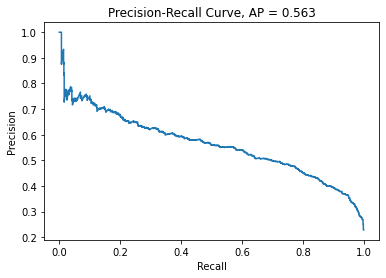

In [17]:
temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/precision_recall.png".format(lead, obs))
plt.show()

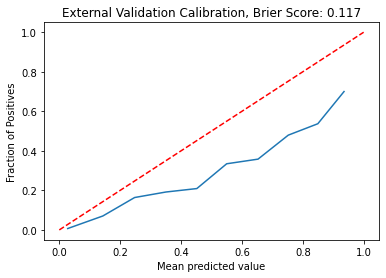

In [18]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/calibration.png".format(lead, obs))
plt.show()


In [19]:
with open("../pickle/relative_{}hr_lead_{}hr_obs/validation/catboost_unpruned_results".format(lead, obs), "wb") as f:
    pickle.dump({"auc" : auc, "fpr" : fpr, "tpr" : tpr, "recall" : temp_recall, "precision" : temp_precision,
    "ap" : ap, "mean_predicted_value" : mean_predicted_value, "fraction_of_positives" : fraction_of_positives,
    "brier" : brier}, f)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


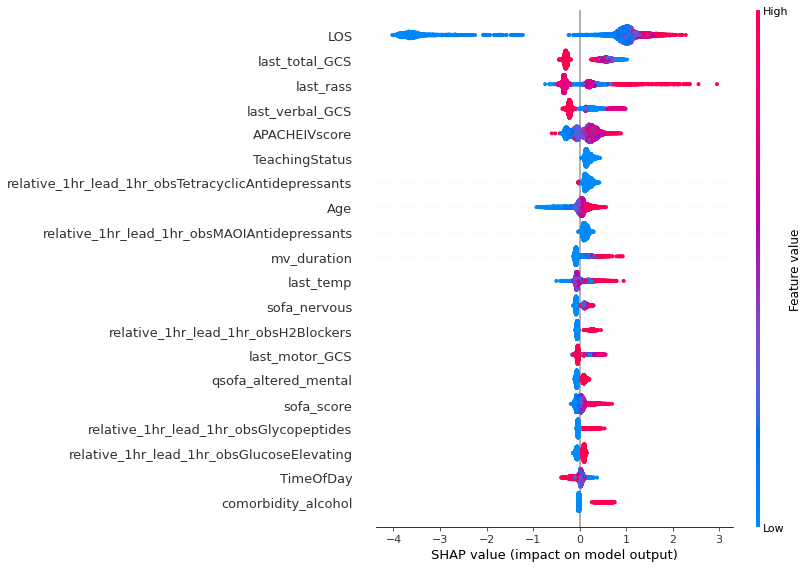

In [20]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(validation.iloc[:, 1:])
shap.summary_plot(shap_values, validation.iloc[:, 1:], show=False)
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/shapley.png".format(lead, obs), bbox_inches="tight")

In [21]:
import pickle
with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/catboost".format(lead, obs), "rb") as f:
    catboost_result = pickle.load(f)
    

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/pr_baseline".format(lead, obs), "rb") as f:
    pr_baseline = pickle.load(f)

result_dict = catboost_result
name = "/relative_{}hr_lead_{}hr_obs/validation/catboost".format(lead, obs)

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1.1])
plt.legend(("Inner Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap),
    "Chance"),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../pickle/relative_1hr_lead_1hr_obs/mean_unpruned/catboost'

## CatBoost Pruned

In [22]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data_pruned.iloc[:, 1:], labels)

Learning rate set to 0.014184
0:	learn: 0.6706131	total: 193ms	remaining: 9m 38s
1:	learn: 0.6501794	total: 215ms	remaining: 5m 22s
2:	learn: 0.6330521	total: 248ms	remaining: 4m 7s
3:	learn: 0.6165536	total: 279ms	remaining: 3m 28s
4:	learn: 0.5986736	total: 324ms	remaining: 3m 14s
5:	learn: 0.5872517	total: 341ms	remaining: 2m 50s
6:	learn: 0.5713399	total: 387ms	remaining: 2m 45s
7:	learn: 0.5559811	total: 461ms	remaining: 2m 52s
8:	learn: 0.5420908	total: 480ms	remaining: 2m 39s
9:	learn: 0.5319937	total: 515ms	remaining: 2m 34s
10:	learn: 0.5229350	total: 563ms	remaining: 2m 33s
11:	learn: 0.5126411	total: 609ms	remaining: 2m 31s
12:	learn: 0.4999410	total: 661ms	remaining: 2m 31s
13:	learn: 0.4891536	total: 681ms	remaining: 2m 25s
14:	learn: 0.4800233	total: 700ms	remaining: 2m 19s
15:	learn: 0.4723824	total: 723ms	remaining: 2m 14s
16:	learn: 0.4638803	total: 743ms	remaining: 2m 10s
17:	learn: 0.4545759	total: 764ms	remaining: 2m 6s
18:	learn: 0.4479276	total: 810ms	remaining: 2

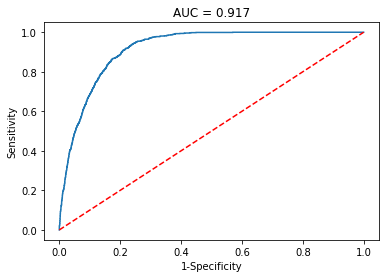

In [25]:
predictions = clf.predict_proba(validation_pruned.iloc[:,1:])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/pruned_roc.png".format(lead, obs))
plt.show()

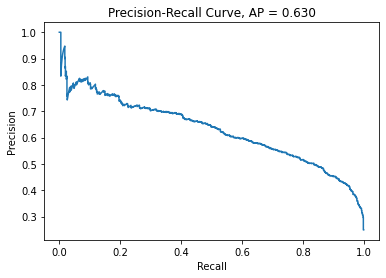

In [26]:
temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/pruned_precision_recall.png".format(lead, obs))
plt.show()

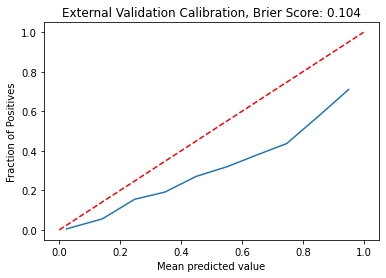

In [27]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/pruned_calibration.png".format(lead, obs))
plt.show()


In [29]:
with open("../pickle/relative_{}hr_lead_{}hr_obs/validation/catboost_pruned_results".format(lead, obs), "wb") as f:
    pickle.dump({"auc" : auc, "fpr" : fpr, "tpr" : tpr, "recall" : temp_recall, "precision" : temp_precision,
    "ap" : ap, "mean_predicted_value" : mean_predicted_value, "fraction_of_positives" : fraction_of_positives,
    "brier" : brier}, f)

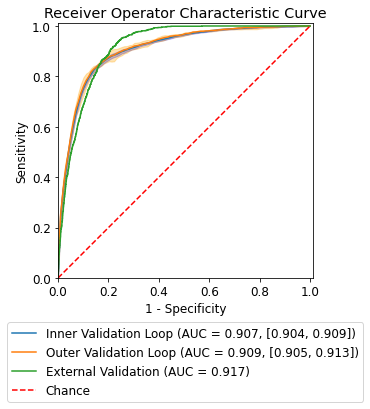

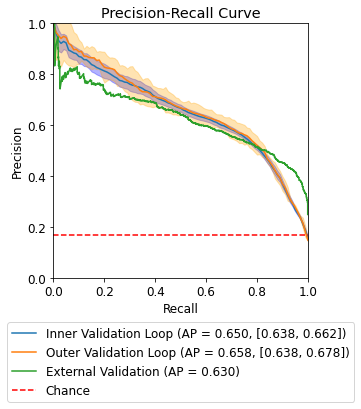

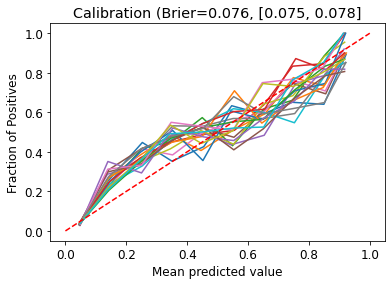

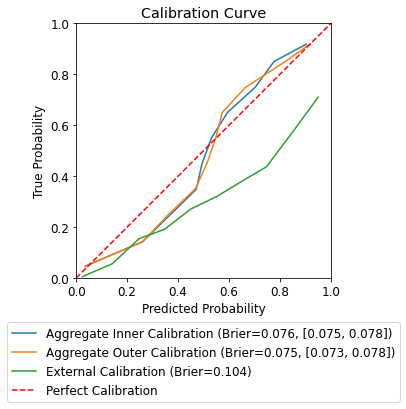

In [30]:
import pickle
with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_pruned/catboost_unbalanced".format(lead, obs), "rb") as f:
    catboost_result = pickle.load(f)
    

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/pr_baseline".format(lead, obs), "rb") as f:
    pr_baseline = pickle.load(f)

result_dict = catboost_result
name = "/relative_{}hr_lead_{}hr_obs/validation/catboost_pruned".format(lead, obs)

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Characteristic Curve")
plt.ylim([0, 1.01])
plt.xlim([0, 1.01])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(("Inner Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap),
    "Chance"),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

o_mid_brier, o_up_brier, o_low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure(figsize=(6,6))
ipred = result_dict["ifullpred"]
ilabels = result_dict["ilabels"]

pred = []
lab = []
for i in range(len(ipred)):
    for j in range(len(ipred[i])):
        pred.append(ipred[i][j])
        lab.append(np.asarray(ilabels[i])[j])

prob_true, prob_pred = calibration_curve(
			lab, pred, n_bins=10
)

plt.plot(prob_true, prob_pred)


opred = result_dict["ofullpred"]
olabels = result_dict["olabels"]

pred = []
lab = []
for i in range(len(opred)):
    for j in range(len(opred[i])):
        pred.append(opred[i][j])
        lab.append(olabels[i][j])

prob_true, prob_pred = calibration_curve(
			lab, pred, n_bins=10
)

plt.plot(prob_true, prob_pred)
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(["Aggregate Inner Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_brier, low_brier, up_brier),
"Aggregate Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}])".format(o_mid_brier, o_low_brier, o_up_brier),
"External Calibration (Brier={0:.3f})".format(brier),
 "Perfect Calibration"],
 loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

In [25]:
np.asarray(ilabels[0])

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

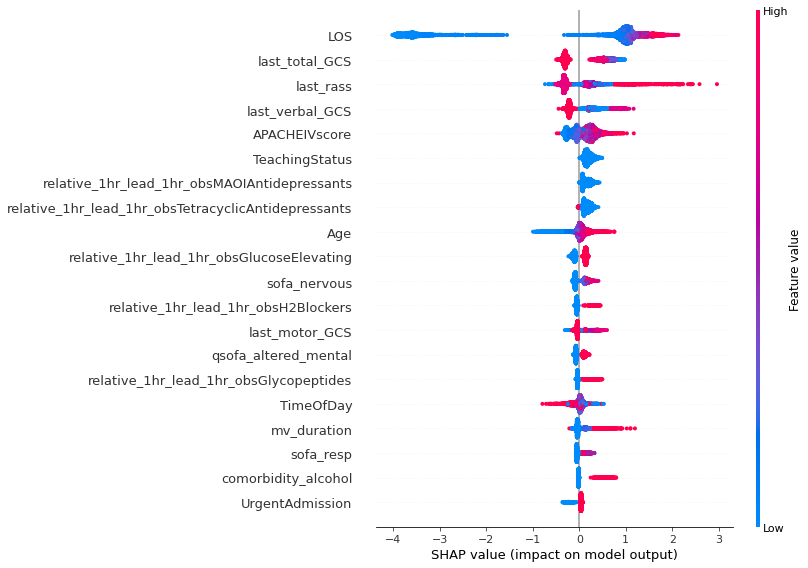

In [19]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(validation_pruned.iloc[:, 1:])
shap.summary_plot(shap_values, validation_pruned.iloc[:, 1:], show=False)
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/catboost_pruned_validation_shapeley.png".format(lead, obs), bbox_inches="tight")

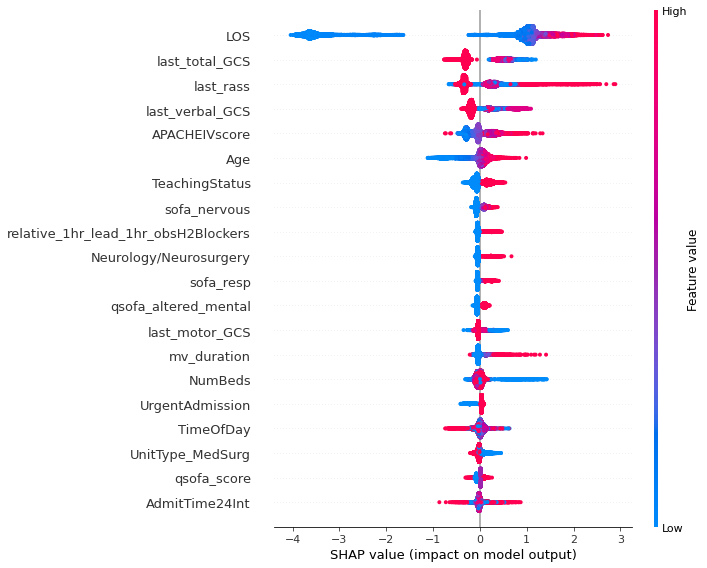

In [20]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_pruned.iloc[:, 1:])
shap.summary_plot(shap_values, data_pruned.iloc[:, 1:], show=False)
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/catboost_pruned_training_shapeley.png".format(lead, obs), bbox_inches="tight")